In [1]:
import numpy as np
import sortednp as snp # operations on sorted arrays
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import math 
import cmath
import mdirac as md
import importlib
importlib.reload(md)
np.set_printoptions(precision=7)

In [2]:
a=3.193 # Angstrom
t=1.105 # eV
vf=t*a # Angstrom*eV
Delta=2.16 # eV
epsilon=4.5 # hBN
r0=45./epsilon # Angstrom
Lunit = vf/Delta # Angstrom

In [3]:
N1=1000
K1=20

In [4]:
### Setup mesh
dr=2.*math.pi/K1 
cell=dr*np.array([[1.,0.],[-0.5,0.5*np.sqrt(3)]])
rmesh = md.Parallelogram(N1,cell)
kmesh = rmesh.reciprocal_cell()
kmesh.hexagon = kmesh.get_hexagon(fraction=0.1)

In [5]:
# Parameter to check BSE complexity: < 100 for laptop calculation
math.sqrt(kmesh.hexagon.Np)

85.73797291748855

In [6]:
# Setup interaction
r0eff=r0/Lunit
epseff=epsilon*(Delta/md.Hartree)*(Lunit/md.Bohr)
keld=md.interaction.Keldysh(epseff,r0eff)

In [7]:
### Two types of quadratures for discretizing the potential
#Wk=md.interaction.sample_to_mesh(keld,kmesh)
Wk=md.interaction.sample_to_mesh(keld,rmesh,quadrature='fft') # fraction<=0.1 for convergence

In [8]:
### Display potential for check
#kmesh.show(c=np.log(np.abs(Wk)),dpi=100,s=0.2)

In [9]:
# ### Direct BSE calculation for check (slow)
# %time Wkk=md.interaction.pairs(kmesh.hexagon,Wk)
# %time H=md.Hbse(E,U,Wkk)
# %time Exfull,UxfullT=np.linalg.eigh(H); Uxfull=UxfullT.T
# Delta*Exfull[:10]
# kmesh.hexagon.show(c=np.abs(Uxfull[0]),s=10,cmap='gnuplot')

In [10]:
### Toeplitz matrix BSE calculation (fast)
%time H=md.Hbse_toeplitz(kmesh.hexagon,Wk)
%time l0Ex,l0UxTsec0=np.linalg.eigh(H); l0Uxsec0=l0UxTsec0.T
%time H=md.Hbse_toeplitz(kmesh.hexagon,Wk,l=2)
%time l2Ex,l2UxTsec0=np.linalg.eigh(H); l2Uxsec0=l2UxTsec0.T

CPU times: user 4.44 s, sys: 47.9 ms, total: 4.49 s
Wall time: 4.51 s
CPU times: user 1.31 s, sys: 48.3 ms, total: 1.36 s
Wall time: 157 ms
CPU times: user 5.42 s, sys: 43.8 ms, total: 5.46 s
Wall time: 3.78 s
CPU times: user 1.74 s, sys: 27.9 ms, total: 1.77 s
Wall time: 187 ms


In [11]:
### Map wavevectors from sector to full hexagon
l0Ux=np.empty((l0Ex.size,kmesh.hexagon.Np),dtype=np.complex128)
l2Ux=np.empty((l2Ex.size,kmesh.hexagon.Np),dtype=np.complex128)
for n in range(l0Ex.size):
    l0Ux[n]=kmesh.hexagon.fill_with(l0Uxsec0[n])
for n in range(l2Ex.size):
    l2Ux[n]=kmesh.hexagon.fill_with(l2Uxsec0[n],l=2)

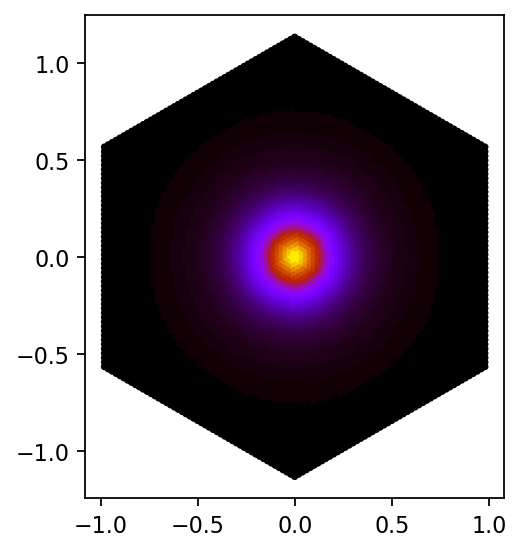

In [12]:
kmesh.hexagon.show(c=np.abs(l0Ux[0]),s=5,cmap='gnuplot')    

In [13]:
E,U=md.eighT(kmesh.hexagon)
dE=E[:,1]-E[:,0]
csxv = md.cov_matrix_elements(md.sx,U)
rcv=csxv/dE

In [14]:
Ex, linds = snp.merge(l0Ex,l2Ex[1:], indices=True)
rx0=np.empty(Ex.size,dtype=np.complex128)
l0xsx0 = md.exciton_elements(l0Ux,csxv)
rx0[linds[0]]=l0xsx0/l0Ex
l2xsx0 = md.exciton_elements(l2Ux[1:],csxv)
rx0[linds[1]]=l2xsx0/l2Ex[1:]

In [15]:
omega=np.linspace(1.e-5,2.,1000)
eta=1.5e-2

In [16]:
factor=kmesh.vcell/(2.*math.pi)**2
chi0=md.get_chi(factor,omega+1j*eta,dE,rcv)
chi=md.get_chi(factor,omega+1j*eta,Ex,rx0)

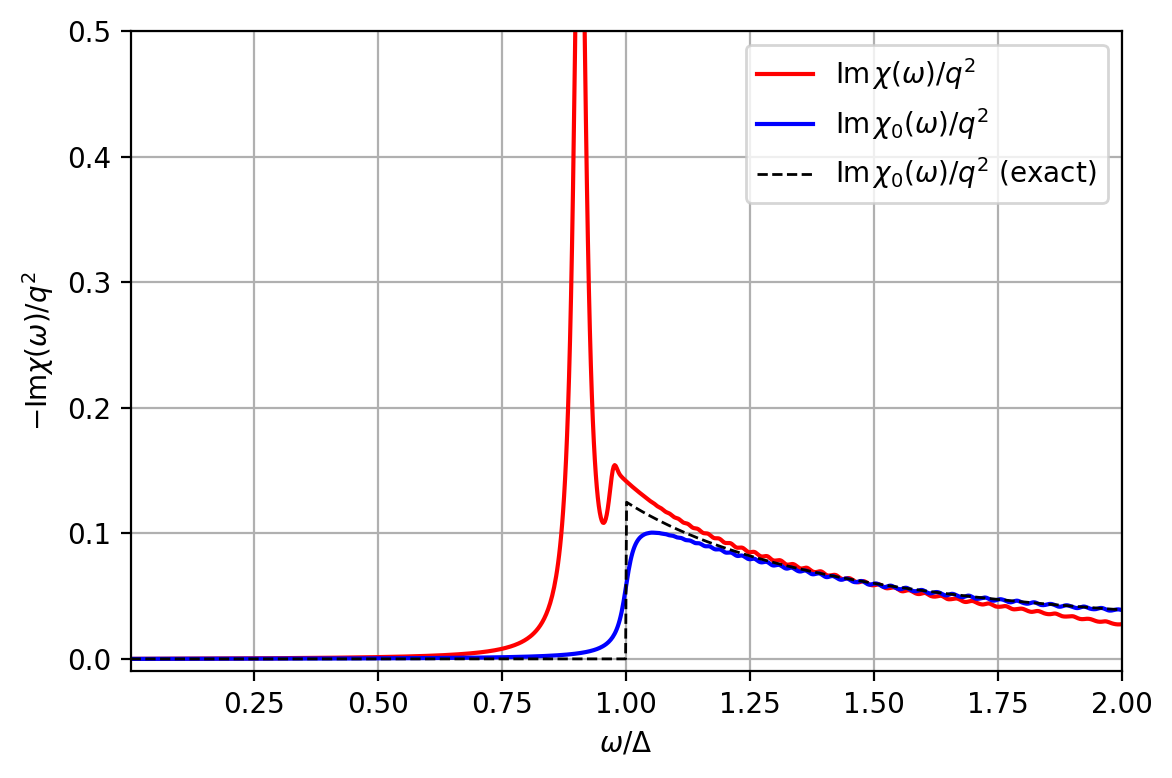

In [17]:
fig,ax=plt.subplots(dpi=100)
ax.plot(omega,-chi.imag,'r',label=r'${\rm Im}\,\chi(\omega)/q^2$')
ax.plot(omega,-chi0.imag,'b',label=r'${\rm Im}\,\chi_0(\omega)/q^2$')
ax.plot(omega,-md.chi0(omega).imag,'k--',lw=1,label=r'${\rm Im}\,\chi_0(\omega)/q^2$ (exact)')
ax.set_xlim([omega[0],omega[-1]])
ax.set_ylim([-0.01,0.5])
ax.set_xlabel(r'$\omega/\Delta$')
ax.set_ylabel(r'$-{\rm Im}\chi(\omega)/q^2$')
ax.grid()
ax.legend(loc='upper right')
fig.tight_layout()
#plt.savefig('chi0.jpg',dpi=150)

In [18]:
### Check the sum rule
print(np.sum(np.abs(rcv)**2*dE**2))
print(np.sum(np.abs(rx0)**2*Ex**2))

5095.045968288625
5095.045968288631


In [19]:
omega=np.linspace(0.88,1.0,1000)
eta=1.e-5
chi=md.get_chi(factor,omega+1j*eta,Ex,rx0)

(0.88, 1.0)

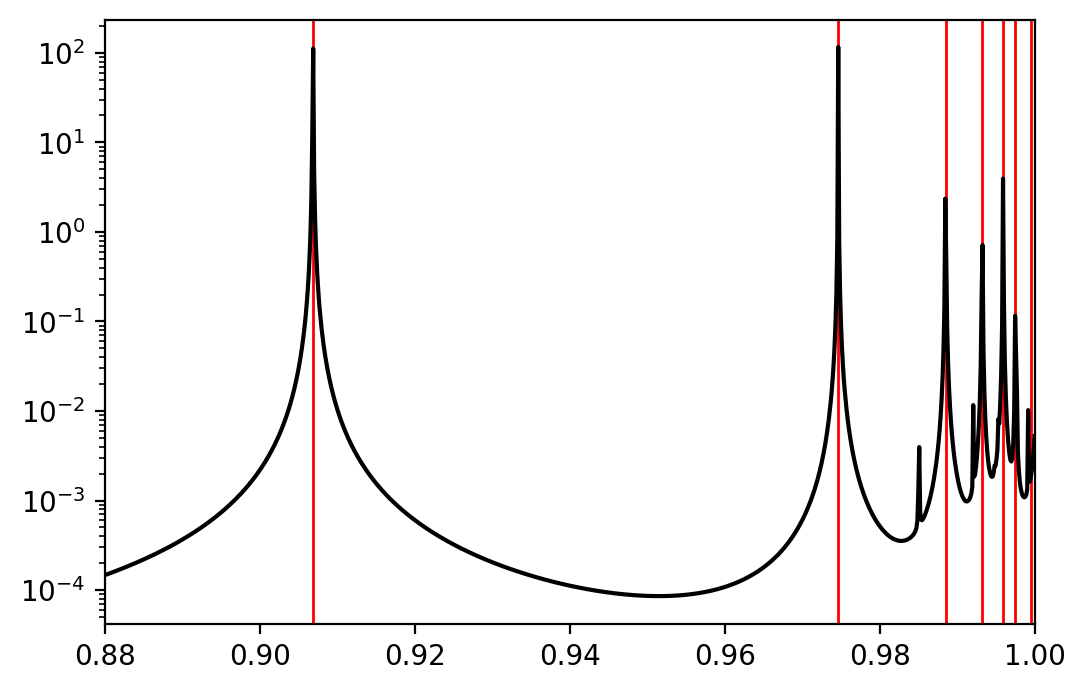

In [23]:
### Exciton Rydberg series
fig,ax=plt.subplots(dpi=100)
inds,=np.where(l0Ex<1)
for n in range(inds.size):    
    ax.axvline(x=l0Ex[n],c='r',ls='solid',lw=1,zorder=1) 
ax.semilogy(omega,-chi.imag,'k')    
ax.axvline(x=Delta,c='k',ls='solid')
ax.set_xlim([omega[0],omega[-1]])